## allesfitter results

In [1]:
ls ~/github/research/project/young_ttvs/allesfitter/toi_in_resonance/toi4495/ttv

params.csv       results/  settings.csv  toi4495_tess.png
params_star.csv  run.py    tess.csv      ttv_preparation/


In [5]:
import numpy as np
import matplotlib.pyplot as plt    
from pprint import pprint
import allesfitter
import seaborn as sb

alles = allesfitter.allesclass('../allesfitter/toi_in_resonance/toi4495/ttv')

colors = {'b': sb.color_palette()[0],
          'c': sb.color_palette()[1]}

target = 'TOI-4495'

Filling the Basement

OrderedDict([('user-given:', ''),
             ('companions_phot', ['b', 'c']),
             ('companions_rv', []),
             ('inst_phot', ['tess']),
             ('inst_rv', []),
             ('multiprocess', True),
             ('multiprocess_cores', '60'),
             ('fast_fit', 'True'),
             ('fast_fit_width', '0.5'),
             ('secondary_eclipse', 'False'),
             ('phase_curve', 'False'),
             ('shift_epoch', True),
             ('inst_for_b_epoch', ['tess']),
             ('mcmc_nwalkers', '100'),
             ('mcmc_total_steps', '2000'),
             ('mcmc_burn_steps', '1000'),
             ('mcmc_thin_by', '2'),
             ('ns_modus', 'dynamic'),
             ('ns_nlive', '1000'),
             ('ns_bound', 'single'),
             ('ns_sample', 'rwalk'),
             ('ns_tol', '0.01'),
             ('host_ld_law_tess', 'quad'),
             ('baseline_flux_tess', 'sample_GP_Matern32'),
             ('error_flux_tess',

In [77]:
from aesthetic.plot import savefig

In [79]:
for companion in alles.settings['companions_all']:
    fig, axes = plt.subplots()
    axes.axhline(0, color='grey', ls='--')
    for i in range(len(alles.data[f'{companion}_tmid_observed_transits'])):
        axes.errorbar(i+1, alles.posterior_params_median[f'{companion}_ttv_transit_'+str(i+1)]*24*60, 
                       yerr=np.array([[alles.posterior_params_ll[f'{companion}_ttv_transit_'+str(i+1)]*24*60, 
                                       alles.posterior_params_ul[f'{companion}_ttv_transit_'+str(i+1)]*24*60 ]]).T, 
                       color=alles.settings[f'{companion}_color'], fmt='.')
    target = alles.BASEMENT.datadir.split('/')[-2]
    axes.set(xlabel='Transit Number.', ylabel='TTV (mins)', title=f'{target}{companion}')
    # savefig(fig, f"{alles.BASEMENT.datadir}/{companion}_ttv.png", writepdf=False)

2024-03-06T02:01:01.709233: made ../allesfitter/toi_in_resonance/toi4495/ttv/b_ttv.png
2024-03-06T02:01:02.100406: made ../allesfitter/toi_in_resonance/toi4495/ttv/c_ttv.png


In [63]:
def get_infos(companion):
    infos = {}
    
    infos['transit_midtime_linear'] = np.array(alles.data[companion+'_tmid_observed_transits'] ) #linear-ephemerides midtimes that fall into the observation windows
    infos['transit_number'] = np.array( [int(np.round( ( t - alles.posterior_params_median[companion+'_epoch'] ) / alles.posterior_params_median[companion+'_period'] ) ) for t in infos['transit_midtime_linear']] )
    infos['N_transits'] = len(infos['transit_number']) #number of linear-ephemerides midtimes that fall into the observation windows
    
    infos['ttv_median'] = np.array([alles.posterior_params_median[companion+'_ttv_transit_'+str(i+1)] for i in range(infos['N_transits'])] )
    ttv_sig = []
    for i in range(infos['N_transits']):
        try:
            ttv_sig.append(np.std(alles.posterior_params[companion+'_ttv_transit_'+str(i+1)]))
        except:
            ttv_sig.append(np.nan)
    infos['ttv_sig'] = np.array(ttv_sig)
    
    infos['ttv_lerr'] = np.array([alles.posterior_params_ll[companion+'_ttv_transit_'+str(i+1)] for i in range(infos['N_transits'])] )
    infos['ttv_uerr'] = np.array([alles.posterior_params_ul[companion+'_ttv_transit_'+str(i+1)] for i in range(infos['N_transits'])] )

    infos['ttv_median'][infos['ttv_median']==0] = np.nan #remove the one we fixed
    infos['ttv_sig'][infos['ttv_sig']==0] = np.nan #remove the one we fixed
    infos['ttv_lerr'][infos['ttv_lerr']==0] = np.nan #remove the one we fixed
    infos['ttv_uerr'][infos['ttv_uerr']==0] = np.nan #remove the one we fixed
    
    infos['transit_midtime_median'] = infos['transit_midtime_linear'] + infos['ttv_median']
    infos['transit_midtime_lerr'] = infos['ttv_lerr']
    infos['transit_midtime_uerr'] = infos['ttv_uerr']
    
    k = ~np.isnan(infos['ttv_median'])
    z = np.polyfit(infos['transit_number'][k], infos['transit_midtime_median'][k], 1)
    p = np.poly1d(z)
    infos['period_linear'] = z[0]
    infos['epoch_linear'] = z[1]
    infos['o_minus_c_median'] = infos['transit_midtime_median'] - p(infos['transit_number'])
    infos['o_minus_c_lerr'] = infos['ttv_lerr']
    infos['o_minus_c_uerr'] = infos['ttv_uerr']
    
    return infos
    
def save_infos(companion, xlim=None):
    infos = get_infos(companion)
    
    t = infos['transit_midtime_linear']
    if xlim:
        idx = (t>=xlim[0]) & (t<=xlim[1])
    else:
        idx = np.ones_like(t, dtype=bool)
    #::: save csv
    header = 'period_linear = '+str(infos['period_linear'])+'\n'+\
             'epoch_linear = '+str(infos['epoch_linear'])+'\n'+\
             'transit_number,transit_midtime_median,transit_midtime_lerr,transit_midtime_uerr,o_minus_c,o_minus_c_lerr,o_minus_c_uerr'
    X = np.column_stack((infos['transit_number'][idx], 
                         infos['transit_midtime_median'][idx], 
                         infos['transit_midtime_lerr'][idx], 
                         infos['transit_midtime_uerr'][idx], 
                         infos['o_minus_c_median'][idx], 
                         infos['o_minus_c_lerr'][idx], 
                         infos['o_minus_c_uerr'][idx]))
    fp = f'{target}_'+companion+'_summary.csv'
    np.savetxt(fp, X, delimiter=',', header=header)
    print("Saved: ", fp)
    
    #::: save latex table
    fp = f'{target}_'+companion+'_latex_table.txt'
    with open(fp,'w') as f:
        f.write('Transit mid-time ($\mathrm{BJD_\{TDB}$) & O-C (min.)\n')
        for i in range(infos['N_transits']):
            a = allesfitter.utils.latex_printer.round_tex(infos['transit_midtime_median'][i], infos['transit_midtime_lerr'][i], infos['transit_midtime_uerr'][i])
            b = allesfitter.utils.latex_printer.round_tex(infos['o_minus_c_median'][i], infos['o_minus_c_lerr'][i], infos['o_minus_c_uerr'][i])
            f.write('$'+a+'$' + ' & ' + '$'+b+'$' + '\\\\\n')
    print("Saved: ", fp)

In [64]:
alles.data.keys()

dict_keys(['tess', 'inst_phot', 'inst_rv', 'inst_rv2', 'b_tmid_observed_transits', 'c_tmid_observed_transits'])

In [65]:
param_names = list(alles.posterior_params.keys())

tcs = {}
tcs_err = {}
for companion in alles.settings['companions_all']:
    tcs[companion] = {}
    tcs_err[companion] = {}
    i = 0
    for name in param_names:
        x = name.split('_')
        if x[0]==companion:
            if x[1]=='ttv':
                tcs[companion][name] = alles.posterior_params_median[name]+np.array(alles.data[companion+'_tmid_observed_transits'])[i]
                tcs_err[companion][name] = np.std(alles.posterior_params[name])
                i+=1

In [66]:
import sys
sys.path.insert(0, '/home/jp/github/research/project/young_ttvs/code/')

from utils import *

In [67]:
df = get_tess_obs_dates(clobber=False)
df.tail()

,Dates,Spacecraft,Camera 1,Camera 2,Camera 3,Camera 4,start,end
Sector,,,,,,,,
79,05/21/24-06/18/24,"266.06, 60.30, 347.51","258.01, 24.74, 83.22","262.17, 48.51, 80.69","274.36, 71.85, 249.88","33.61, 80.77, 131.93",2460451.5,2460479.5
80,06/18/24-07/15/24,"275.70, 32.23, 5.49","278.93, -3.64, 94.65","276.91, 20.28, 94.95","274.11, 44.17, 276.48","267.10, 67.88, 282.42",2460479.5,2460506.5
81,07/15/24-08/10/24,"292.57, 34.69, 17.13","302.54, -0.09, 104.02","296.39, 23.16, 105.27","287.51, 46.06, 290.43","265.96, 67.26, 308.80",2460506.5,2460532.5
82,08/10/24-09/05/24,"309.13, 39.78, 27.80","325.16, 6.78, 111.16","315.49, 28.98, 114.19","300.44, 50.10, 303.97","265.65, 66.52, 334.11",2460532.5,2460558.5
83,09/05/24-10/01/24,"325.89, 47.12, 37.05","347.50, 15.88, 115.23","334.93, 37.15, 120.95","312.93, 56.07, 317.26","266.16, 65.80, 358.80",2460558.5,2460584.5


In [75]:
t0 = alles.data[companion+'_tmid_observed_transits'][0]
t0

2458683.1653759996

In [68]:
companion='b'
epoch = alles.posterior_params_median[companion+'_epoch']
period = alles.posterior_params_median[companion+'_period']
n0=round((epoch-2458687.8460258087)/period)
n0

107

In [69]:
n0+(2459392.7514577424-epoch)/period

136.00252061836002

In [70]:
print("planet,epoch,tc,tc_unc,sector")
for pl,companion in enumerate(alles.settings['companions_all']):
    epoch = alles.posterior_params_median[companion+'_epoch']
    period = alles.posterior_params_median[companion+'_period']
    for i,(k,tc) in enumerate(tcs[companion].items()):
        sec = get_sector(tc)
        n = round((tc-epoch)/period)
        if i==0:
            n0=n
        tc_err = tcs_err[companion][k]
        diff_mins = (tc-(n*period+epoch))*24*60
        err_mins = tc_err*24*60
#         print(f"{pl},{n-n0},{tc},{tc_err},{sec}")
#         print(diff_mins,err_mins)
        if (abs(diff_mins) < 60) and (err_mins<30):
            print(f"{pl},{n-n0},{tc},{tc_err},{sec}")

planet,epoch,tc,tc_unc,sector
0,0,2458687.8460274916,0.004689044147412481,14
0,2,2458698.2080894588,0.00451241658143922,14
0,3,2458703.3984894054,0.0044349334399804,14
0,136,2459392.7514573364,0.003573236610061015,40
0,137,2459397.9392454647,0.004335965824355925,40
0,138,2459403.11452637,0.003962361356145899,40
0,139,2459408.2904030974,0.0036906358301934147,40
0,140,2459413.474278568,0.0035003679418148027,40
0,141,2459418.6624482996,0.004303092563918023,41
0,142,2459423.8345479644,0.004292284484670947,41
0,143,2459429.0195817132,0.0035721156672576986,41
0,144,2459434.1967433854,0.003735294256210866,41
0,145,2459439.3768563126,0.006151074245217202,41
0,146,2459444.5640156604,0.0037793280738431015,41
0,204,2459745.186381996,0.005598093364093797,53
0,206,2459755.557088658,0.004500618778525995,53
0,207,2459760.7420956492,0.004518447740908737,53
0,208,2459765.9272483075,0.004621752709768432,53
0,209,2459771.1102706054,0.004449495916648436,54
0,210,2459776.3037150055,0.004887569448432802,54


In [71]:
np.allclose(tmm, tml+tm, atol=1e-3)

False

In [72]:
def plot_ttv(companion, ax, 
             xaxis='transit_midtime_linear', 
             toffset=None,
             xlim=None, label=None):
    """xaxis=['transit_number','transit_midtime_linear']"""
    infos = get_infos(companion)
    toffset = int(min(infos[xaxis]))
    if xaxis=='transit_midtime_linear':
        x=infos[xaxis]-toffset
    else:
        x=infos['transit_number']
    y=infos['o_minus_c_median']*24*60
    yerr1 = infos['o_minus_c_lerr']*24*60
    yerr2 = infos['o_minus_c_uerr']*24*60
        
    if xlim:
        idx = (x>=xlim[0]) & (x<=xlim[1])
    else:
        idx = np.ones_like(x, dtype=bool)
    
    ax.errorbar(x[idx], y[idx], yerr=[yerr1[idx], yerr2[idx]], 
                marker='o', ls='none', color=colors[companion], label=label)
    if xaxis=='transit_midtime_linear':
        ax.set_xlabel(f'BJD-{toffset}')
    else:
        ax.set_xlabel('Transit number')
    ax.set_ylabel('O-C (min)')
    return ax

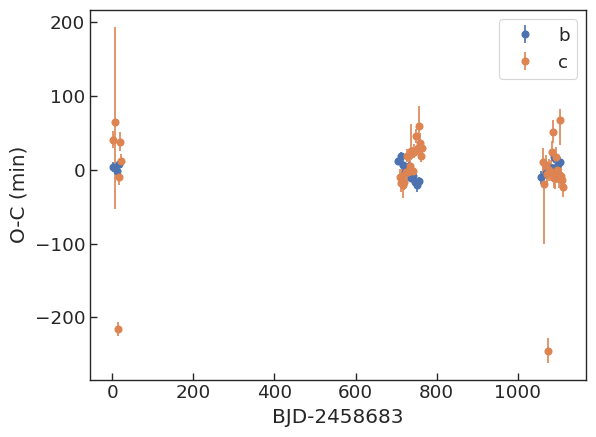

In [73]:
fig, ax = plt.subplots()

ax=plot_ttv('b', ax, label='b')
ax=plot_ttv('c', ax, label='c')
ax.legend()

In [72]:
save_infos('b', xlim=(2200,2600))
save_infos('c', xlim=(2200,2600))

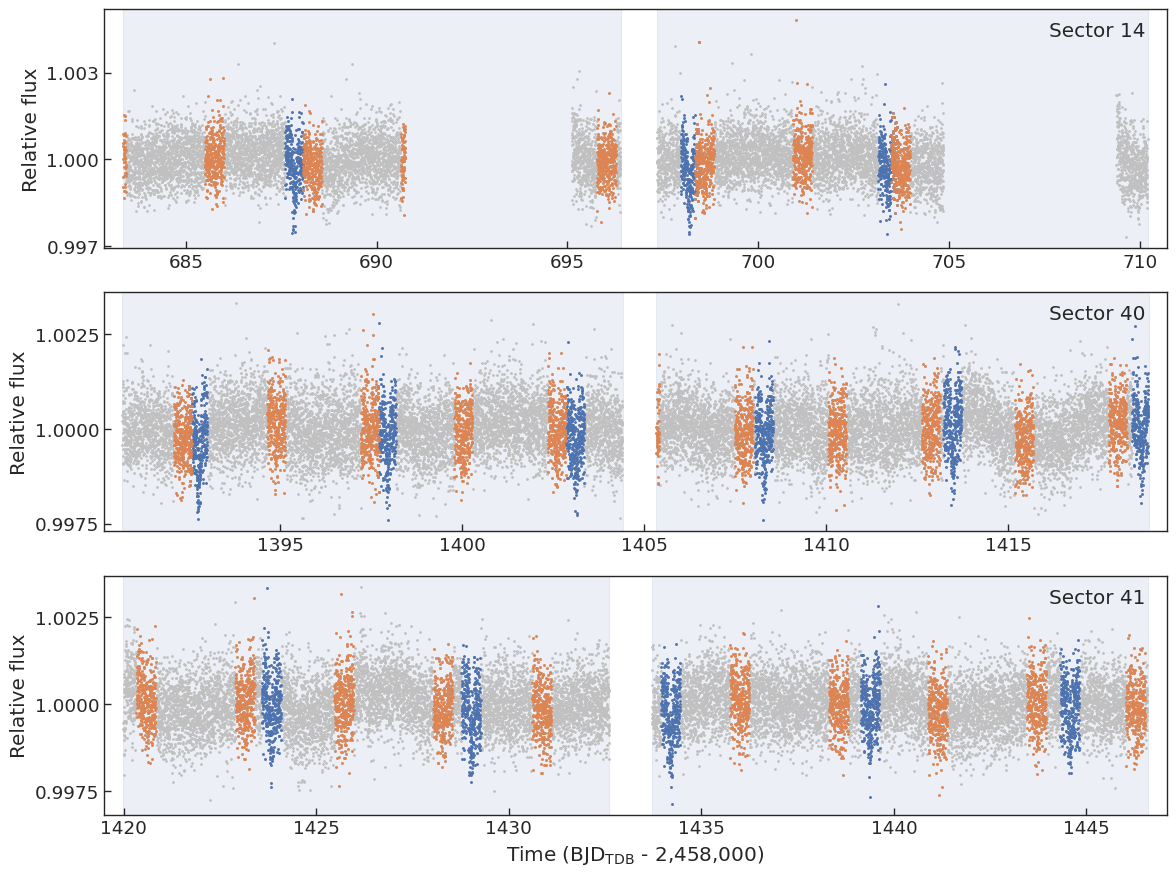

In [38]:
import allesfitter
from allesfitter.lightcurves import eclipse_width_smart
from allesfitter.exoworlds_rdx.lightcurves.index_transits import index_transits, get_tmid_observed_transits
from allesfitter.plotting import fullplot, brokenplot, chunkplot, tessplot


style = 'tessplot'
window = alles.settings['fast_fit_width']
#----------------------------------------------------------------------
#::: get the combined, full data from all instruments
#----------------------------------------------------------------------
time_combined = []
flux_combined = []
for inst in alles.settings['inst_phot']:
    time_combined += list(alles.fulldata[inst]['time'])
    flux_combined += list(alles.fulldata[inst]['flux'])
ind_sort = np.argsort(time_combined)
time_combined = np.array(time_combined)[ind_sort]
flux_combined = np.array(flux_combined)[ind_sort]

axes = tessplot(time_combined, flux_combined, color='silver')

#::: mark the tranists/eclipses of each photometric companion
for i, c in enumerate(alles.settings['companions_phot']):
    ind_tr, ind_out = index_transits(time_combined, alles.posterior_params_median[c+'_epoch'], alles.posterior_params_median[c+'_period'], window)
    axes = tessplot(time_combined[ind_tr], flux_combined[ind_tr], color=alles.settings[c+'_color'], axes=axes, label=c)

## rotation period

In [2]:
import sys
sys.path.insert(0, '/home/jp/github/research/project/young_ttvs/code')
from gls import Gls

In [19]:
import pandas as pd

df = pd.read_csv('/home/jp/github/research/project/young_ttvs/allesfitter/toi4495/tess.csv', names=['t','f','e'])
df

,t,f,e
0,2.458683e+06,1.000876,0.000635
1,2.458683e+06,0.999034,0.000634
2,2.458683e+06,0.999996,0.000634
3,2.458683e+06,1.000565,0.000634
4,2.458683e+06,1.000457,0.000634
...,...,...,...
80780,2.459796e+06,0.999514,0.000617
80781,2.459796e+06,1.000605,0.000617
80782,2.459796e+06,0.999686,0.000617
80783,2.459796e+06,0.998727,0.000617


/home/jp/github/research/project/young_ttvs/code/gls.py:757: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


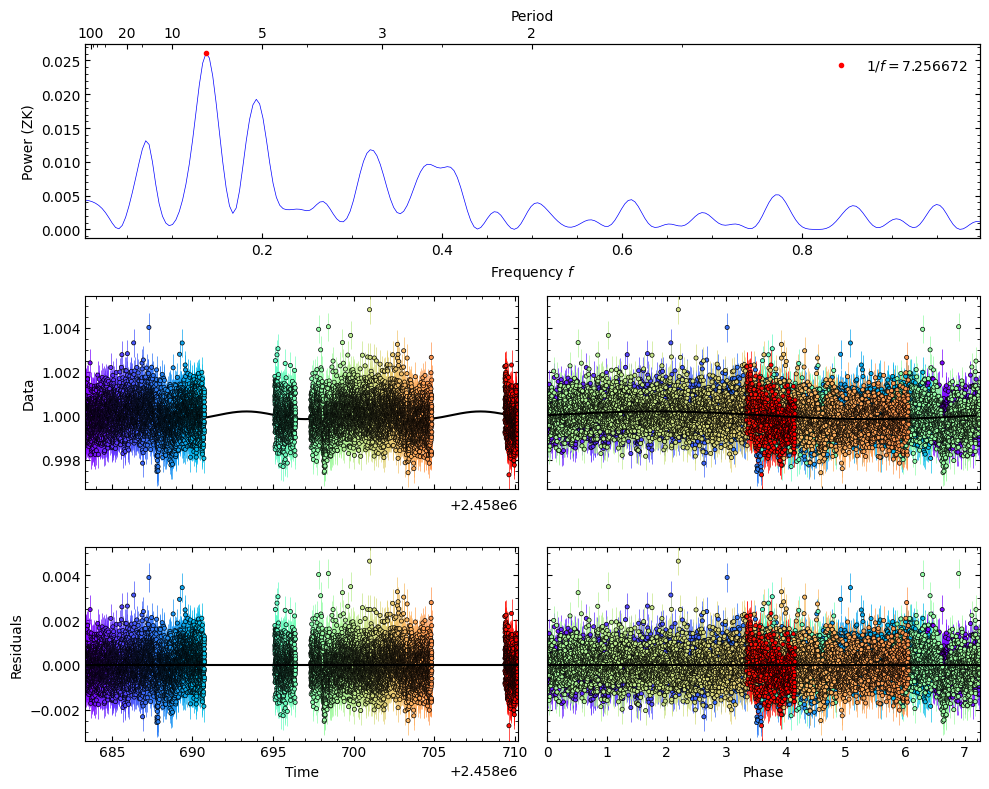

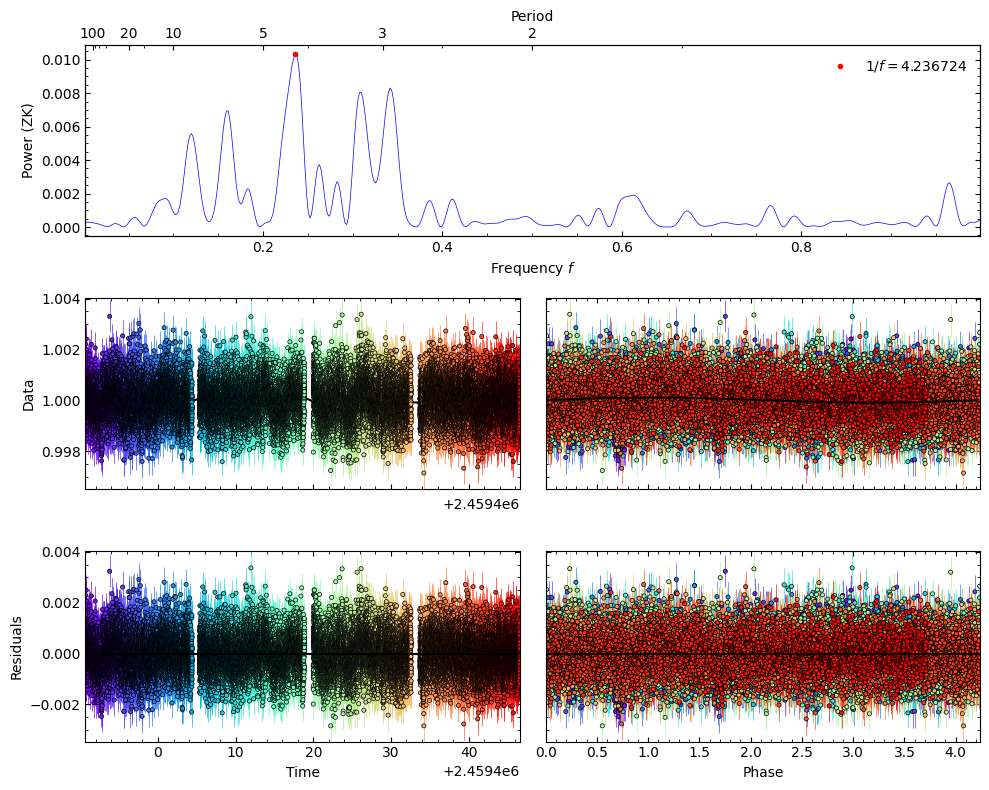

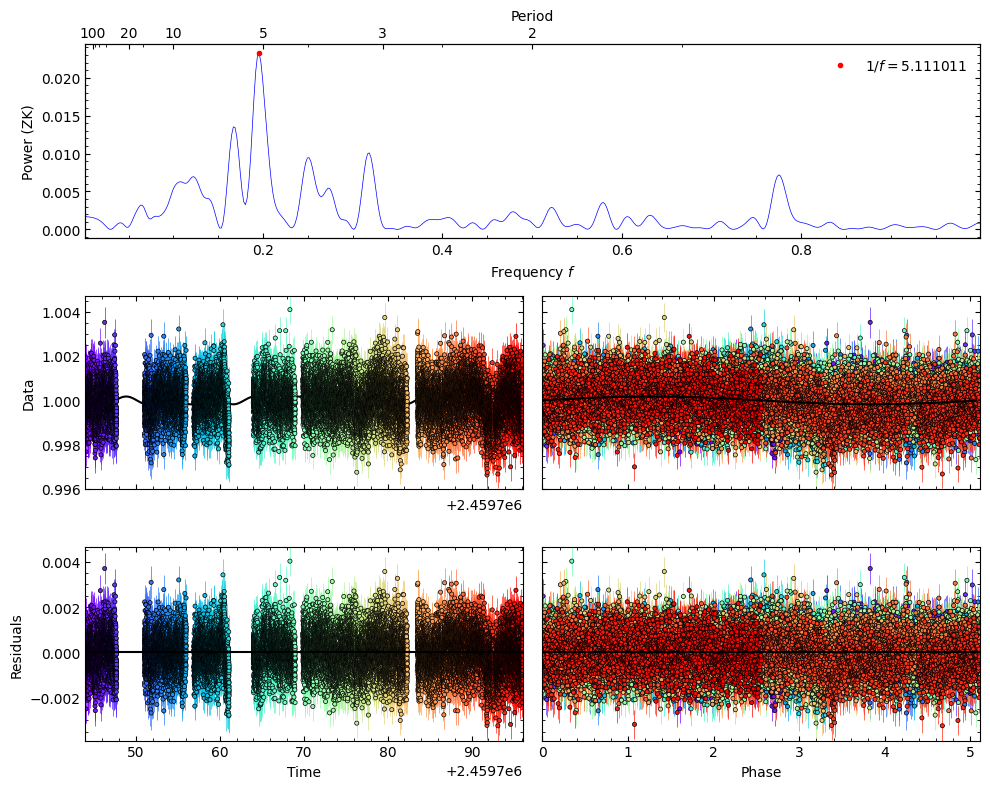

In [21]:
xlims = [(1400,2000),(2200,2600), (2600,3000)]
c = 2457000

for x1,x2 in xlims:
    idx = (df.t>=x1+c) & (df.t<=x2+c)    
    d = df[idx]
    data = d.T.to_numpy()
    gls = Gls(data)
    fig = gls.plot();